<a href="https://colab.research.google.com/github/MahmutRuzi/photonics-sim-examples/blob/main/Quasi_BIC_aSi_nanobars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Quasi-bound states in the continuum (BIC)

In this example, we simulate the transmitance spectrum of arrays of amorphous silicone nanobars periodically (square lattice) placed on a glass substrate. For simulations, we use the rigorosuly coupled wave analysis approach (RCWA), as implemented in torcwa (https://github.com/kch3782/torcwa). The aim is to reproduce Fig.1 b (left) from a published work by Hui-Hsin Hsiao et al. Adv. Optical Mater. 2022, 10, 2200812. https://doi.org/10.1002/adom.202200812. The whole simulation takes around 20 minutes in free version of colab (Standard GPU).

Author: Mahmut Ruzi

Contact: mruzi17@gmail.com

We first check if GPU acceleration using cuda is enabled.


In [ ]:
import torch
torch.cuda.is_available()

True

Let's install the RCWA package torcwa.

In [ ]:
!pip3 install torcwa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's import relevant packages. 

In [ ]:
import time
import torch
import numpy as np
from numpy import savez_compressed 
from matplotlib import pyplot as plt

import torcwa
torch.backends.cuda.matmul.allow_tf32 = True
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

Now Let's set up the simulations. The wavelengths are from 1300 nm to 1500 nm and there is a very sharp peak around 1450 nm, so we simulate for a total of 450 wavelengths. The refractive indices are the same as the ones used in the referenced paper, which are 3.5 for the amorphous silicon (aSi_eps = $3.5^2$), 1.5 for the glass substrate (glass_eps = $1.5^2$), 1.4 for the encapsulation layer (encap_eps = $1.4^2$). 

In [ ]:
# dielectric constants
aSi_eps = 3.5**2
glass_eps = 1.5**2
encap_eps = 1.4**2

# wavelength
lamba  = np.linspace(1300,1500,500)  # nm

# geometry
L = [880, 880]            # nm, period
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = 1000
torcwa.rcwa_geo.ny = 1000
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000.

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()

# layers
Lx = 150. # length along the X axis, in nm
Ly = 300. # width along the y axis, in nm
dx = 380. # center to center separation axis of the two amosphous silicon nanobars
geometry1 = torcwa.rcwa_geo.rectangle(Wx=Lx,Wy=Ly,Cx=L[0]/2.- dx/2,Cy=L[1]/2., theta=-20/180*np.pi) # cloclwise rotation angle wrt y axis
geometry2 = torcwa.rcwa_geo.rectangle(Wx=Lx,Wy=Ly,Cx=L[0]/2.+ dx/2,Cy=L[1]/2., theta=20/180*np.pi)  # anticloclwise rotation angle wrt y axis
layer0_geometry = torcwa.rcwa_geo.union(geometry1, geometry2)
layer0_thickness = 450.
encap_thickness = layer0_thickness + 30


Plot to view the layer to make sure it is the desired structure.

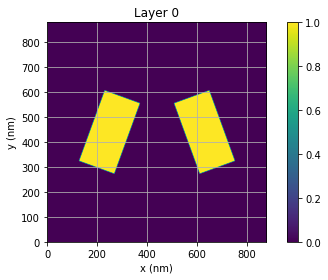

In [ ]:
# View layers
plt.figure(2)
plt.imshow(torch.transpose(layer0_geometry,-2,-1).cpu(),origin='lower',extent=[x_axis[0],x_axis[-1],y_axis[0],y_axis[-1]])
plt.title('Layer 0')
plt.xlim([0,L[0]])
plt.xlabel('x (nm)')
plt.ylim([0,L[1]])
plt.ylabel('y (nm)')
plt.colorbar()
plt.grid()
plt.tight_layout()

Simulation domain

In [ ]:
# Generate and perform simulation
order_Nx = 10 # Fourier truncation order
order_Ny = 10
order = [order_Nx,order_Ny]
lamb0 = torch.tensor(lamba,dtype=geo_dtype,device=device) #Wavelength in nm
#%%
# Simulation environment
# light
start_time = time.time()
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian
input_eps = 1**2  # air

t_xx = []

k = 0


for lamb0_ind in range(len(lamb0)):

    lamb0_now = lamb0[lamb0_ind]
    sim = torcwa.rcwa(freq=1/lamb0_now,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=input_eps)
    #silicon_eps = eps_cSi(lamb0_now.cpu()/1000)
    sim.add_output_layer(eps=glass_eps)
    
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    
    layer0_eps = layer0_geometry*encap_eps + (1.-layer0_geometry)
    layer1_eps = layer0_geometry*aSi_eps + (1.-layer0_geometry)
    
    sim.add_layer(thickness=encap_thickness, eps=encap_eps)
    sim.add_layer(thickness=layer0_thickness, eps=layer1_eps)
    
    
    sim.solve_global_smatrix()
    t_xx.append(sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='pp',ref_order=[0,0]))
    print(format(lamb0_now.cpu().numpy()),format(torch.abs(t_xx[k]).cpu().numpy()))
    k=k+1
    
t_xx = torch.cat(t_xx)

1300.0 [0.8709572]
1300.4007568359375 [0.87214017]
1300.8016357421875 [0.8732248]
1301.202392578125 [0.87460023]
1301.6031494140625 [0.8756129]
1302.0040283203125 [0.8766993]
1302.40478515625 [0.87796915]
1302.8056640625 [0.8793846]
1303.2064208984375 [0.8804279]
1303.607177734375 [0.8814735]
1304.008056640625 [0.8828202]
1304.4088134765625 [0.8840725]
1304.8095703125 [0.8854107]
1305.21044921875 [0.88685215]
1305.6112060546875 [0.8884382]
1306.0120849609375 [0.88947964]
1306.412841796875 [0.89078563]
1306.8135986328125 [0.89253134]
1307.2144775390625 [0.8936219]
1307.615234375 [0.89536697]
1308.0159912109375 [0.8968319]
1308.4168701171875 [0.8982499]
1308.817626953125 [0.8997394]
1309.2183837890625 [0.90139776]
1309.6192626953125 [0.90307105]
1310.02001953125 [0.9048808]
1310.4208984375 [0.90629655]
1310.8216552734375 [0.9079443]
1311.222412109375 [0.91008824]
1311.623291015625 [0.9115225]
1312.0240478515625 [0.91371256]
1312.4248046875 [0.9156424]
1312.82568359375 [0.91739136]
1313.2

now plot to visialize the results

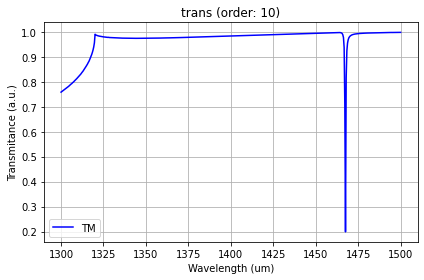

In [ ]:
plt.figure(3)
plt.plot(lamb0.cpu(),torch.abs(t_xx).cpu()**2,'b-')
plt.title('trans (order: '+str(order_Nx)+')')
plt.xlabel('Wavelength (um)')
plt.ylabel('Transmitance (a.u.)')
plt.grid()
plt.tight_layout()
plt.legend(['TM'])

No plot to visulaize the the simulations done for the structure. 

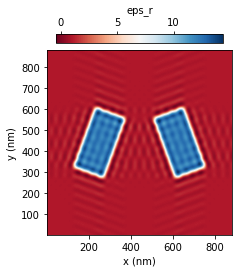

In [ ]:
eps_r= sim.return_layer(layer_num=1, nx=2000, ny=2000)
x1=eps_r[0]
x2=eps_r[1]

plt.figure(5)
#plt.title('Layer 0')
#cax = plt.axes([0.1, 0, 0.8, 0.01]) #Left,bottom, length, width
#clb=plt.colorbar(cax=cax,orientation="vertical")
plt.imshow(torch.transpose(torch.real(x1),-2,-1).cpu(),origin='lower',cmap='RdBu',
           extent=[x_axis[0],x_axis[-1],y_axis[0],y_axis[-1]],aspect=L[1]/L[0])
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.colorbar(location='top', shrink=0.5, aspect=20, anchor=(0.5,0.3),pad=0.0,label='eps_r')